In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
pd.options.display.float_format = '{:.4f}'.format
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
%load_ext autoreload
%autoreload 2
%matplotlib inline

from perturbseq import *

# Load data

In this case we have to load the full raw expression data as some neighboring genes will have zero expression and hence are not included in the processed HDF5 data

In [2]:
pop = CellPopulation.from_file('/home/tmn/sequencing/gi/gi')
pop = pop.subpopulation(cells='single_cell')

Loading digital expression data: /home/tmn/sequencing/gi/gi/outs/filtered_gene_bc_matrices_mex/GRCh38/matrix.mtx...
Densifying matrix...
Loading guide identities:/home/tmn/sequencing/gi/gi/outs/cell_identities.csv...
Generating summary statistics...
Done.
Generating summary statistics...
Done.


In [3]:
# add metadata
name_replacer = {'C3orf72': 'FOXL2NB',
                 'C19orf26': 'CBARP',
                 'KIAA1804': 'RP5-862P8.2'
                }

pop.cells['guide_target'] = pop.cells['guide_identity'].map(lambda x: x.split('__')[0])
pop.cells['num_targets'] = pop.cells['guide_target'].map(lambda x: len(x.split('_')))
pop.cells['guide_target_1'] = pop.cells['guide_target'].map(lambda x: x.split('_')[0])
pop.cells['guide_target_2'] = ''
pop.cells.loc[pop.cells['num_targets'] == 2, 'guide_target_2'] = pop.cells.loc[pop.cells['num_targets'] == 2, 'guide_target'].map(lambda x: x.split('_')[1])
pop.cells['guide_target_1'] = pop.cells['guide_target_1'].map(lambda x: name_replacer.get(x, x))
pop.cells['guide_target_2'] = pop.cells['guide_target_2'].map(lambda x: name_replacer.get(x, x))
pop.cells['guide_target'] = pop.cells['guide_target_1'] + '_' + pop.cells['guide_target_2']

control_targets = np.setdiff1d(pop.cells.groupby('guide_target').count().sort_values('number_of_cells', ascending=False).head(4).index.values,
                               'NegCtrl1_NegCtrl0')
pop.cells['perturbed'] = pop.cells['guide_target'].map(lambda x: 'control' if x in control_targets else x)

In [4]:
# make control population
control_targets = np.setdiff1d(pop.cells.groupby('guide_target').count().sort_values('number_of_cells', ascending=False).head(4).index.values,
                                'NegCtrl1_NegCtrl0')

control_pop = pop.subpopulation(cells='perturbed == "control"')

# make mean population
mean_pop = pop.average('guide_target', show_progress=True)

# add metadata
mean_pop.cells['first_target'] = mean_pop.cells.index.map(lambda x: x.split('_')[0])
mean_pop.cells['second_target'] = mean_pop.cells.index.map(lambda x: x.split('_')[1])
mean_pop.cells['guide_target'] = mean_pop.cells.index
mean_pop.cells['num_targets'] = 2 - mean_pop.cells.index.str.count('NegCtrl')
mean_pop.cells['first_id'] = mean_pop.cells['first_target'].map(lambda x: mean_pop.gene_ids(x))
mean_pop.cells['second_id'] = mean_pop.cells['second_target'].map(lambda x: mean_pop.gene_ids(x))

mean_pop.add_property(cells=mean_pop.metaapply({'first_expr': lambda meta, expr: expr.loc[meta.name, meta['first_id']],
                                                 'second_expr': lambda meta, expr: expr.loc[meta.name, meta['second_id']],
                                                }))
mean_pop.add_property(cells=metaapply(mean_pop.cells, control_pop.genes,
                      {'control_first_expr': lambda meta, expr: expr.loc[meta['first_id'], 'mean'],
                       'control_second_expr': lambda meta, expr: expr.loc[meta['second_id'], 'mean'],
                      }))
mean_pop.cells['fold_first_expr'] = mean_pop.cells['first_expr']/mean_pop.cells['control_first_expr']
mean_pop.cells['fold_second_expr'] = mean_pop.cells['second_expr']/mean_pop.cells['control_second_expr']
mean_pop.cells['log_fold_first_expr'] = np.log10(mean_pop.cells['fold_first_expr'])
mean_pop.cells['log_fold_second_expr'] = np.log10(mean_pop.cells['fold_second_expr'])
mean_pop.cells['diff_first_expr'] = mean_pop.cells['first_expr'] - mean_pop.cells['control_first_expr']
mean_pop.cells['diff_second_expr'] = mean_pop.cells['second_expr'] - mean_pop.cells['control_second_expr']
mean_pop.cells['pct_first_expr'] = mean_pop.cells['diff_first_expr']/mean_pop.cells['control_first_expr']
mean_pop.cells['pct_second_expr'] = mean_pop.cells['diff_second_expr']/mean_pop.cells['control_second_expr']
mean_pop.cells['log_control_first_expr'] = np.log10(mean_pop.cells['control_first_expr'])
mean_pop.cells['log_control_second_expr'] = np.log10(mean_pop.cells['control_second_expr'])

Generating summary statistics...
Done.
Computing average expression matrices...


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


Computing clusters...


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


Generating summary statistics...
Done.


perturbseq/cell_population.py:1329: UserWarning: Function application containing missing keys that were replaced by nans.
  warnings.warn('Function application containing missing keys that were replaced by nans.')
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10


# Bootstrap test for altered mean expression

In [5]:
from scipy.stats import ttest_ind, ttest_1samp

def bootstrap_t(xhat, yhat, alpha=0.01, n=10000):
    
    base_tvalues = dict()
    for gene in xhat.columns:
        base_tvalues[gene] = ttest_ind(xhat[gene], yhat[gene], equal_var=False)[0]
    base_tvalues = pd.Series(base_tvalues)

    group_mean = pd.concat([xhat, yhat]).mean()
    xhat = xhat - xhat.mean() + group_mean
    yhat = yhat - yhat.mean() + group_mean
        
    tvalues = dict()

    for i in range(0, n):
        test_series = dict()
        x_sample = xhat.sample(frac=1, replace=True)
        y_sample = yhat.sample(frac=1, replace=True)
        for gene in x_sample.columns:
            test_series[gene] = ttest_ind(x_sample[gene], y_sample[gene], equal_var=False)[0]
        tvalues[i] = pd.Series(test_series)
        
    tvalues = pd.DataFrame(tvalues)
    pvalues = dict()

    for gene in tvalues.index:
        if np.isnan(base_tvalues.loc[gene]):
            pvalues[gene] = 1
        else:
            pvalues[gene] = np.sum(tvalues.loc[gene].abs() > np.abs(base_tvalues.loc[gene]))/(float(n) + 1)
    pvalues = pd.Series(pvalues) 
        
    return pvalues < alpha, pvalues

In [6]:
def bootstrap_ratio(x, y, alpha=0.05, n=10000, eps=1e-7):
    support, p = bootstrap_t(x, y, alpha=alpha, n=n)
    ratio = x.mean()/(y.mean() + eps)
    ratio[support[~support].index] = 1
    ratio[ratio == 0] = 1
    return ratio.loc[x.columns], p.loc[x.columns]

In [7]:
def get_sub_matrices(pop, control_pop, target, genes, scale=False):
    subpop_matrix = pop.matrix.loc[pop.cells.query('guide_target == @target').index, genes]
    control_matrix = control_pop.matrix[genes]
    
    if scale:
        subpop_median = pop.cells.query('guide_target == @target')['UMI_count'].median()
        control_median = control_pop.cells['UMI_count'].median()
        scale_factor = control_median/subpop_median
        subpop_matrix = subpop_matrix*scale_factor

    return subpop_matrix, control_matrix

In [8]:
# def mean_cis(xhat, yhat, n=1000):
#     x_cis = dict()
#     y_cis = dict()

#     for gene in xhat.columns:
#         if not (xhat[gene] == 0).all():
#             x_cis[gene] = bootstrap.ci(data=xhat[gene].values, n_samples=n)
#         else:
#             x_cis[gene] = np.array([0, 0])

#         if not (control_pop.matrix[gene] == 0).all():
#             y_cis[gene] = bootstrap.ci(data=yhat[gene].values, n_samples=n)
#         else:
#             y_cis[gene] = np.array([0, 0])
            
#     x_cis = pd.DataFrame(x_cis).T.rename(columns={0: 'x_low', 1: 'x_high'})
#     y_cis = pd.DataFrame(y_cis).T.rename(columns={0: 'y_low', 1: 'y_high'})
#     result = pd.merge(x_cis, y_cis, left_index=True, right_index=True)
#     result['x_mean'] = xhat.mean()
#     result['y_mean'] = yhat.mean()
    
#     return result.loc[xhat.columns]

In [9]:
# def bootstrap_t1samp(xhat, mean, alpha=0.01, n=1000):
    
#     base_tvalues = dict()
#     for gene in xhat.columns:
#         base_tvalues[gene] = ttest_1samp(xhat[gene], mean)[0]
#     base_tvalues = pd.Series(base_tvalues)
        
#     xhat = xhat - xhat.mean()
        
#     tvalues = dict()

#     for i in range(0, n):
#         test_series = dict()
#         x_sample = xhat.sample(frac=1, replace=True)
#         for gene in x_sample.columns:
#             test_series[gene] = ttest_1samp(x_sample[gene], mean)[0]
#         tvalues[i] = pd.Series(test_series)
        
#     tvalues = pd.DataFrame(tvalues)
#     pvalues = dict()

#     for gene in tvalues.index:
#         if np.isnan(base_tvalues.loc[gene]):
#             pvalues[gene] = 1
#         else:
#             pvalues[gene] = np.sum(tvalues.loc[gene].abs() > np.abs(base_tvalues.loc[gene]))/(float(n) + 1)
#     pvalues = pd.Series(pvalues) 
        
#     return pvalues < alpha, pvalues

# Get neighboring genes for each targeted gene

Made a GTF file containing only genes from the cellranger references by running

awk '$3 == "gene"' genes.gtf > cellranger-GRCh38-1.2.0_only_genes.gtf

In [10]:
gene_list = pd.read_csv('./data_sharing/cellranger-GRCh38-1.2.0_only_genes.gtf',
            sep='\t',
            header=None,
            names=['chr', 'source', 'type', 'start', 'end', 'null1', 'orientation', 'null2', 'notes'])

gene_list = gene_list[['chr', 'source', 'type', 'start', 'end', 'orientation', 'notes']]
gene_list['gene_id'] = gene_list['notes'].map(lambda x: x.split('"')[1])
gene_list['gene_name'] = gene_list['notes'].map(lambda x: x.split('"')[5])
gene_list['gene_type'] = gene_list['notes'].map(lambda x: x.split('"')[9])

protein_gene_list = gene_list[gene_list['gene_type'] == "protein_coding"]
protein_gene_list.reset_index(inplace=True)

Get list of genes neighboring each targeted gene for all single perturbations

In [11]:
n = 20 # number of neighbors to look at
neighborhood_expr = dict()
control_neighborhood_expr = dict()
neighboring_genes = dict()

single_genes = np.setdiff1d(mean_pop.cells.query('num_targets == 1')['guide_target'].unique(), control_targets)
single_genes_and_targets = {gene: gene.replace('_NegCtrl0', '').replace('NegCtrl0_', '') for gene in single_genes}

for perturbation, gene in single_genes_and_targets.iteritems():
    idx = gene_list[gene_list['gene_name'] == gene].index[0]
    neighboring_genes[perturbation] = gene_list.iloc[np.arange(idx - n, idx + n + 1)]['gene_id']
    neighborhood = mean_pop.matrix.loc[perturbation][neighboring_genes[perturbation]]
    neighborhood.index = pd.Index(np.arange(0 - n, 0 + n + 1))
    neighborhood_expr[perturbation] = neighborhood
    control_neighborhood = control_pop.genes.loc[neighboring_genes[perturbation]]['mean']
    control_neighborhood.index = pd.Index(np.arange(0 - n, 0 + n + 1))
    control_neighborhood_expr[perturbation] = control_neighborhood

neighborhood_expr = pd.DataFrame(neighborhood_expr)
control_neighborhood_expr = pd.DataFrame(control_neighborhood_expr)

Get single cell expression matrices for each perturbation of all genes surrounding the target of the sgRNA

In [12]:
from tqdm import tqdm_notebook

control_Ms = dict()
perturbed_Ms = dict()

for perturbation, gene in tqdm_notebook(single_genes_and_targets.iteritems()):
    M, M_cont = get_sub_matrices(pop, control_pop, perturbation, neighboring_genes[perturbation].values, scale=True)
    if M.shape[0] == 0 or M_cont.shape[0] == 0:
        continue
    control_Ms[perturbation] = M_cont
    perturbed_Ms[perturbation] = M

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

In [13]:
# this is very slow...
from joblib import Parallel, delayed

out = Parallel(n_jobs=10, verbose=10)(delayed(bootstrap_ratio)(perturbed_Ms[perturbation],
                                                               control_Ms[perturbation]) for perturbation in perturbed_Ms.keys())

[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:  3.0min
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  5.8min
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:  8.7min
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  9.6min
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed: 14.7min
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed: 17.7min
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed: 20.7min
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed: 23.9min
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed: 29.4min
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed: 32.9min
[Parallel(n_jobs=10)]: Done 125 tasks      | elapsed: 38.5min
[Parallel(n_jobs=10)]: Done 149 out of 152 | elapsed: 44.6min remaining:   53.9s
[Parallel(n_jobs=10)]: Done 152 out of 152 | elapsed: 46.8min finished


In [14]:
ratios = {gene: zip(*out)[0][i] for i, gene in enumerate(perturbed_Ms.keys())}
pvalues = {gene: zip(*out)[1][i] for i, gene in enumerate(perturbed_Ms.keys())}

# Beautifying results

This is just some data munging for visual presentation. We set the 0 point for each neighborhood of genes to be the center of the targeted ORF. We also flip all the neighbors for genes that fall on the negative strand so that in the visualization the direction of transcription is the same for all columns.

In [17]:
protein_gene_list['midpoint'] = (protein_gene_list['start'] + protein_gene_list['end'])/2
gene_list['midpoint'] = (gene_list['start'] + gene_list['end'])/2

df = gene_list.set_index('gene_id')
centered_ratios = dict()

for gene in single_genes:
    r = ratios[gene]
    d = df.loc[r.index].copy()

    if d.iloc[n]['orientation'] == '+':
        offset = d.iloc[n]['start']
        d['midpoint'] = d['midpoint'] - offset
        d['start'] = d['start'] - offset
        d['end'] = d['end'] - offset
        print gene
    else: #swap genes where ORFs are on negative strand
        offset = d.iloc[n]['end']
        d['midpoint'] = d['midpoint'] - offset
        temp = d['start'].copy()
        d['start'] = -(d['end'] - offset)
        d['end'] = -(temp - offset)
        print gene + "... flipping"
    
    d['ratio'] = r
    centered_ratios[gene] = d[['ratio', 'midpoint', 'start', 'end']]

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


AHR_NegCtrl0
ARID1A_NegCtrl0
ARRDC3_NegCtrl0... flipping
ATL1_NegCtrl0
BAK1_NegCtrl0... flipping
BCL2L11_NegCtrl0
BCORL1_NegCtrl0
BPGM_NegCtrl0
CBARP_NegCtrl0... flipping
CBFA2T3_NegCtrl0... flipping
CBL_NegCtrl0
CDKN1A_NegCtrl0
CDKN1B_NegCtrl0
CDKN1C_NegCtrl0... flipping
CEBPA_NegCtrl0... flipping
CEBPB_NegCtrl0
CEBPE_NegCtrl0... flipping
CELF2_NegCtrl0
CITED1_NegCtrl0... flipping
CKS1B_NegCtrl0
CLDN6_NegCtrl0... flipping
CNN1_NegCtrl0
CNNM4_NegCtrl0
COL1A1_NegCtrl0... flipping
COL2A1_NegCtrl0... flipping
CSRNP1_NegCtrl0... flipping
DLX2_NegCtrl0... flipping
DUSP9_NegCtrl0
EGR1_NegCtrl0
ELMSAN1_NegCtrl0... flipping
ETS2_NegCtrl0
FEV_NegCtrl0... flipping
FOSB_NegCtrl0
FOXA1_NegCtrl0... flipping
FOXA3_NegCtrl0
FOXF1_NegCtrl0
FOXL2NB_NegCtrl0
FOXL2_NegCtrl0... flipping
FOXO4_NegCtrl0
GLB1L2_NegCtrl0
HES7_NegCtrl0... flipping
HK2_NegCtrl0
HNF4A_NegCtrl0
HOXA13_NegCtrl0... flipping
HOXB9_NegCtrl0... flipping
HOXC13_NegCtrl0
IER5L_NegCtrl0... flipping
IGDCC3_NegCtrl0... flipping
IKZF3_NegCt

More beautifying, and morphing the data into the format that Bokeh expects for plotting. Add real gene names and flag genes that have very large effects on gene expression (affecting total UMI count), which may be expected to have more differentially expressed genes on average.

In [18]:
annotated_centered_ratios = dict()

for gene, frame in centered_ratios.iteritems():
    frame = frame.copy()
    frame['target'] = gene
    frame['gene_name'] = pop.genes.loc[frame.index, 'gene_name']
    annotated_centered_ratios[gene] = frame
    
df = pd.concat(annotated_centered_ratios.values()).reset_index()
df['ratio'] = np.log2(df['ratio'])
df['target_gene'] = df['target'].map(lambda x: x.replace('NegCtrl0_', '').replace('_NegCtrl0', ''))
df['index'] = df.index

# flag perturbations that induce large changes in UMI content relative to control cells
single_guide_pop = mean_pop.cells.loc[single_genes]
low_targets = single_guide_pop[single_guide_pop['UMI_count'] < 0.8*mean_pop.cells.loc['NegCtrl11_NegCtrl0', 'UMI_count']].index.values
low_mapper = {name: name + ' #' if name in low_targets else name for name in df['target'].unique()}
df['target'] = df['target'].map(low_mapper)

sort_order = df.sort_values(['target_gene', 'target', 'index']).groupby('target').head(1)['target'].reset_index(drop=True)
order_mapper = {name: '{0:03d} {1}'.format(n, name) for n, name in sort_order.iteritems()}
df['target'] = df['target'].map(lambda x: order_mapper[x])

Now render the figure using Bokeh

In [19]:
from bokeh.io import show, reset_output
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LinearColorMapper,
    BasicTicker,
    PrintfTickFormatter,
    ColorBar,
    Range1d,
    Paragraph
)
from bokeh.plotting import figure
import bokeh.palettes
from math import pi
from bokeh.io import output_notebook, output_file, reset_output
from bokeh.layouts import column
from matplotlib.colors import to_hex

In [20]:
first_pos_df = df[df['target'].str.contains('_NegCtrl0')]
first_pos_df.target = first_pos_df.target.map(lambda x: ' '.join(x.split(' ')[1:]))

/usr/local/lib/python2.7/dist-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [21]:
reset_output()

In [22]:
source = ColumnDataSource(first_pos_df)
TOOLS = "hover,save,pan,box_zoom,reset,wheel_zoom"

colors = [to_hex(plt.cm.get_cmap('RdBu_r')(x)) for x in np.linspace(0, 1, 19)]
colors = colors[:9] + ['#d6d6d6',] + colors[10:]
mapper = LinearColorMapper(palette=colors, low=-5, high=5)

p = figure(title='CRISPRa activation of targets and nearby genes',
        x_range=sorted(first_pos_df['target'].unique()), y_range=Range1d(-5e5, 5e5),
           y_axis_label='Distance from midpoint of targeted gene (bp)',
           x_axis_label='Targeted gene',
           x_axis_location="below", plot_width=2400, plot_height=1000,
           tools=TOOLS, toolbar_location='above',
          lod_threshold=1000000)

p.vbar(x="target", bottom="start", top="end",
       width=0.8,
       source=source,
       fill_color={'field': 'ratio', 'transform': mapper},
       line_color=None)

p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "16pt"
p.axis.major_label_standoff = 0
p.yaxis.axis_label_text_font_style = "normal"
p.xaxis.axis_label_text_font_style = "normal"
p.xaxis.axis_label_text_font_size = "22pt"
p.yaxis.axis_label_text_font_size = "22pt"

p.xaxis.major_label_orientation = pi / 2
p.toolbar.logo = None
p.min_border_top = 80

color_bar = ColorBar(color_mapper=mapper, major_label_text_font_size="12pt",
                     ticker=BasicTicker(desired_num_ticks=len(colors)),
                     formatter=PrintfTickFormatter(format="%.1f"),
                     border_line_color=None, location=(0, 0))
p.add_layout(color_bar, 'right')

p.select_one(HoverTool).tooltips = [
     ('Gene', '@gene_name'),
     ('Target', '@target'),
     ('Log2 fold', '@ratio')
]

In [23]:
output_file('./figures/neighboring_genes.html')

In [24]:
show(p)

Finally, plot a figure showing the activation for all neighboring genes.

In [28]:
target_index = first_pos_df.query('start == 0').index
target_features = first_pos_df.loc[target_index]
neighbor_features_1 = first_pos_df.loc[target_index - 1].query('ratio != 0')
neighbor_features_2 = first_pos_df.loc[target_index + 1].query('ratio != 0')

In [29]:
neighbor_features_1.query('ratio > 1 or ratio < -1').to_csv('./data_sharing/activated_neighbors_1.csv')

In [30]:
neighbor_features_2.query('ratio > 1 or ratio < -1').to_csv('./data_sharing/activated_neighbors_2.csv')

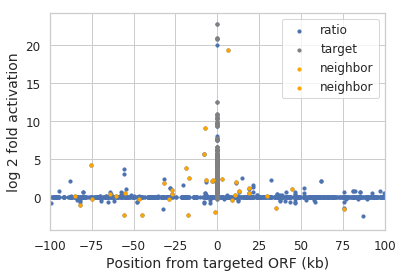

In [31]:
plt.scatter(df['start']/1000, df['ratio'], s=10)
plt.scatter(target_features['start']/1000, target_features['ratio'], s=10, color='gray', label='target')
plt.scatter(neighbor_features_1['start']/1000, neighbor_features_1['ratio'], s=10, color='orange', label='neighbor')
plt.scatter(neighbor_features_2['start']/1000, neighbor_features_2['ratio'], s=10, color='orange', label='neighbor')

plt.xlabel('Position from targeted ORF (kb)')
plt.ylabel('log 2 fold activation')
plt.legend()
plt.xlim([-1e2, 1e2]);
plt.savefig('./figures/activation_of_neighboring_genes.pdf', bbox_inches='tight')